# Imports

In [12]:
import pandas as pd
import numpy as np

In [13]:
def print_row(item, decimals=2):
    if type(item) == str:
        print(f'& {item} ', end='')    
    else: print(f'& {np.round(item, decimals):03} ', end='')

In [14]:
dataset_full_form = {
    'electricity': 'Electricity',
    'traffic': 'Traffic',
    'mimic_iii': 'MIMIC-III'
}

In [15]:
def reduce_df(df:pd.DataFrame):
    # df[df['area']==0.05]
    return df.groupby('metric')[['comp', 'suff']].aggregate('mean').reset_index()

int_metric_map = {
    'electricity': ['mae'],
    'traffic': ['mae'],
    'mimic_iii': ['auc']
}

test_metric_map = {
    'electricity': ['mae', 'mse'],
    'traffic': ['mae', 'mse'],
    'mimic_iii': ['auc', 'accuracy']
}

datasets = ['electricity', 'traffic', 'mimic_iii']
models = ['DLinear', 'MICN', 'SegRNN', 'iTransformer']
attr_methods = [
    'feature_ablation',
    'augmented_occlusion', 
    'feature_permutation', 
    'integrated_gradients', 
    'gradient_shap','dyna_mask',
    'winIT', 'tsr', 'wtsr'
]

short_form = {
    'feature_ablation': 'FA',
    'occlusion':'FO',
    'augmented_occlusion': 'AFO',
    'feature_permutation': 'FP',
    'winIT': 'WinIT',
    'tsr':'TSR',
    'wtsr': 'WinTSR',
    'gradient_shap': 'GS',
    'integrated_gradients': 'IG',
    'dyna_mask': 'DM'
}
NUM_ITERATIONS = 3

# Summarize

## Take average

In [16]:
import os

results = []
for dataset in datasets:
    for attr_method in attr_methods:
        for metric in int_metric_map[dataset]:
            for model in models:
                for itr_no in range(1, NUM_ITERATIONS+1):
                    attr_file = f'results/{dataset}_{model}/{itr_no}/{attr_method}.csv'
                    df = pd.read_csv(attr_file)
                        
                    df = reduce_df(df)
                    comp, suff= df[df['metric']==metric][['comp', 'suff']].values[0]
                    
                    results.append([
                        dataset, attr_method, metric, model, itr_no, comp, suff
                    ])
                    # break     

result_df = pd.DataFrame(results, columns=['dataset', 'attr_method', 'metric', 'model', 'itr_no', 'comp', 'suff'])
result_df.head(3)

,dataset,attr_method,metric,model,itr_no,comp,suff
0,electricity,feature_ablation,mae,DLinear,1,10.860281,12.558014
1,electricity,feature_ablation,mae,DLinear,2,10.433965,12.210792
2,electricity,feature_ablation,mae,DLinear,3,10.852369,12.406156


In [17]:
# import os
# import sys

# walk_dir = 'results'

# print('walk_dir = ' + walk_dir)
# print('walk_dir (absolute) = ' + os.path.abspath(walk_dir))

# for root, subdirs, files in os.walk(walk_dir):
#     # print('--\nroot = ' + root)
#     # print('list_file_path = ' + list_file_path)

#     for filename in files:
#         file_path = os.path.join(root, filename)
#         if filename in ['tsr.csv', 'batch_tsr.csv']: 
#             os.remove(file_path)

In [18]:
result_df = result_df.groupby(['dataset', 'attr_method', 'metric', 'model'])[['comp', 'suff']].mean().reset_index()
result_df = result_df[result_df['metric'].isin(['mae', 'auc'])]

selected = result_df['metric'].isin(['auc', 'accuracy'])
result_df.loc[selected, ['comp', 'suff']] = 1 - result_df[selected][['comp', 'suff']]

## Ranking

In [19]:
result_df['comp_rank'] = result_df.groupby(['dataset', 'metric', 'model'])['comp'].rank(ascending=False)
result_df['suff_rank'] = result_df.groupby(['dataset', 'metric', 'model'])['suff'].rank(ascending=True)
_ = result_df.groupby(['dataset', 'metric', 'attr_method'])[['comp_rank', 'suff_rank']].mean().reset_index()

In [20]:
df = pd.concat([
    result_df.drop(columns='suff_rank').rename(columns={'comp_rank': 'rank'}), 
    result_df.drop(columns='comp_rank').rename(columns={'suff_rank': 'rank'})
], axis=0)

ranks = df.groupby(['dataset', 'metric', 'attr_method'])['rank'].mean().round(1).reset_index(name='mean_rank')
ranks['rank'] = ranks.groupby(['dataset', 'metric'])['mean_rank'].rank()
ranks['median_rank'] = df.groupby(['dataset', 'metric', 'attr_method'])['rank'].median().reset_index(drop=True)

## Latex table 

In [24]:
for dataset in datasets:
    # use the first or second on
    for metric in int_metric_map[dataset]:
        print(f'Dataset {dataset}, metric {metric}.\n')
        print(f" & {' & '.join(models)} & {' & '.join(models)} \\\\ \\hline")
        
        for attr_method in attr_methods:
            print(f'{short_form[attr_method]} ', end='')
            for metric_type in ['comp', 'suff']:
                for model in models:
                    scores = []
                    dfs = []
                    for itr_no in range(1, NUM_ITERATIONS+1):
                        df = pd.read_csv(f'results/{dataset}_{model}/{itr_no}/{attr_method}.csv') 
                    
                        df = df[df['metric']==metric][['area', metric_type]]
                        dfs.append(df)
                
                    df = pd.concat(dfs, axis=0)
                    df.replace([np.inf, -np.inf], np.nan, inplace=True)
                    if metric in ['auc', 'accuracy']:
                        df[metric_type] = 1-df[metric_type]
                    
                    rank = result_df[
                        (result_df['dataset']==dataset) & (result_df['metric']==metric) & (result_df['attr_method']==attr_method) & (result_df['model'] == model)
                    ][f'{metric_type}_rank'].values[0]
                    
                    score = df[metric_type].mean()
                    if dataset == 'mimic_iii':
                        score = f'{score:.2f}'
                    else:
                        score = f'{score:.1f}'
                        
                    if rank == 1:
                        print_row(r'\textbf{' + score + '}')
                    elif rank == 2:
                        print_row(r'\underline{' + score + '}')
                    else:
                        print_row(score)
                        
            
            mean_rank, rank = ranks[
                (ranks['dataset']==dataset) & (ranks['metric']==metric) & (ranks['attr_method']==attr_method)
            ][['mean_rank', 'rank']].values[0]
            
            print_row(f'{rank:.0f}({mean_rank})')
            print('\\\\')
        print('\\hline\n')

Dataset electricity, metric mae.

 & DLinear & MICN & SegRNN & iTransformer & DLinear & MICN & SegRNN & iTransformer \\ \hline
FA & \underline{10.7} & 12.0 & 11.0 & 10.7 & 12.4 & \underline{11.1} & 13.4 & \underline{16.3} & 2(2.6) \\
AFO & 10.0 & 11.1 & 10.2 & 9.1 & 13.0 & 12.1 & 14.0 & 17.3 & 3(4.1) \\
FP & 7.0 & 9.4 & 7.9 & 7.0 & 16.0 & 14.1 & 15.6 & 19.3 & 8(7.0) \\
IG & 10.7 & \textbf{13.7} & \underline{11.8} & \textbf{16.1} & 19.0 & 16.3 & 15.1 & 24.8 & 6(5.0) \\
GS & 7.7 & 10.3 & 9.1 & 8.2 & 17.4 & 14.6 & 15.3 & 20.4 & 7(6.9) \\
DM & 3.6 & 7.1 & 3.9 & 3.9 & 16.6 & 14.5 & 16.9 & 20.5 & 9(8.4) \\
WinIT & 10.6 & 9.6 & 9.9 & 8.8 & 13.5 & 13.7 & 14.6 & 17.4 & 6(5.0) \\
TSR & 8.4 & 11.7 & 7.7 & 7.7 & \underline{11.9} & 14.1 & \textbf{12.0} & 16.4 & 4(4.6) \\
WinTSR & \textbf{11.8} & \underline{12.7} & \textbf{12.7} & \underline{12.7} & \textbf{11.3} & \textbf{9.8} & \underline{12.1} & \textbf{14.5} & 1(1.4) \\
\hline

Dataset traffic, metric mae.

 & DLinear & MICN & SegRNN & iTransfor

## Pyplot table

### Utils

In [11]:
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from matplotlib import cm
import matplotlib.pyplot as plt
from utils.plot_config import *

%matplotlib inline

In [93]:
def get_merged(dataset):
    df = result_df[result_df['dataset']==dataset]
    comp = df.pivot(
        index='attr_method', columns='model', values='comp'
    ).reset_index()
    comp['attr_method'] = comp['attr_method'].apply(lambda x: short_form[x])
    comp.set_index('attr_method', inplace=True)
    
    suff = df.pivot(
        index='attr_method', columns='model', values='suff'
    ).reset_index()
    suff['attr_method'] = suff['attr_method'].apply(lambda x: short_form[x])
    suff.set_index('attr_method', inplace=True)
    
    ranks_ = ranks[ranks['dataset']==dataset].copy()
    ranks_['attr_method'] = ranks_['attr_method'].apply(lambda x: short_form[x])
    ranks_.drop(columns=['dataset', 'metric'], inplace=True)
    ranks_.set_index('attr_method', inplace=True)
    
    merged = pd.merge(comp, suff, on='attr_method', how='inner')
    merged = pd.merge(merged, ranks_, on='attr_method', how='inner')
    merged = merged.loc[[short_form[attr] for attr in attr_methods]]
    
    return merged

In [94]:
def get_definitions(merged):
    if merged.max()[0] < 1:
        formatter=lambda x: round(x, 2)
    else:
        formatter=lambda x: round(x, 1)
    
    textprops = {
        "ha": "center",
        "bbox": {"boxstyle": "ellipse", "pad": 0.1},
    }
    
    col_defs = (
        [
            ColumnDefinition(name='attr_method', title='Method', textprops={
                "ha": "center"})
        ] + [
            ColumnDefinition(
                name=f'{model}_x', title=model, 
                cmap=normed_cmap(merged[f'{model}_x'], cmap=cm.BuGn),
                group='Comprehensiveness',
                textprops=textprops, 
                formatter=formatter,
                width=1.2 if model == 'iTransformer' else 1,
                border="left" if i == 0 else None
            )
            for i, model in enumerate(models)
        ]+ [
            ColumnDefinition(
                name=f'{model}_y', title=model, 
                cmap=normed_cmap(merged[f'{model}_y'], cmap=cm.BuGn_r),
                group='Sufficiency',
                textprops=textprops, formatter=formatter,
                width=1.2 if model == 'iTransformer' else 1,
                border="left" if i == 0 else None
            )
            for i, model in enumerate(models)
        ] + [
            ColumnDefinition(
                name='mean_rank', title='Avg', group='Rank',
                textprops={"ha": "center"}, formatter=lambda x: round(x, 1),
                cmap=normed_cmap(merged['mean_rank'], cmap=cm.BuGn_r),
                border="left"
            ),
            ColumnDefinition(
                name='rank', title='Overall', group='Rank',
                formatter=lambda x: int(x),
                textprops={
                    "ha": "center", 
                    # "bbox": {"boxstyle": "ellipse", "pad": 0.1},
                },
                cmap=normed_cmap(merged['rank'], cmap=cm.BuGn_r),
                
            )
        ]
    )
    
    return col_defs

### Plot

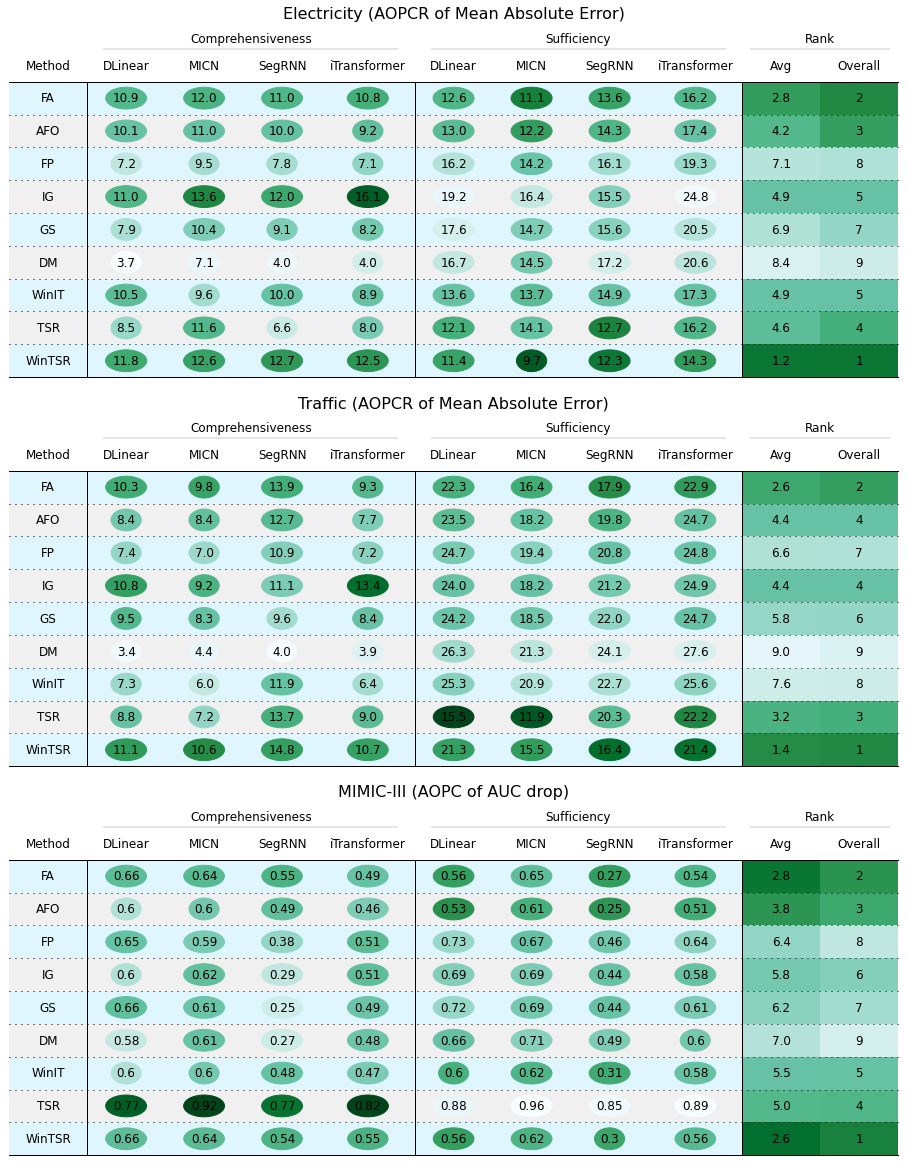

In [95]:
fig, axes = plt.subplots(len(datasets), 1, figsize=(16, 21))

for i in range(len(datasets)):
    ax = axes[i]
    dataset = datasets[i]
    
    merged = get_merged(dataset)
    col_defs = get_definitions(merged)

    table = Table(
        merged,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 12},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        odd_row_color="#f0f0f0", even_row_color="#e0f6ff"
    )
    
    if dataset== 'mimic_iii':
        ax.set_title(f'{dataset_full_form[dataset]} (AOPC of AUC drop)', fontsize=16, y=.95)
    else:
        ax.set_title(f'{dataset_full_form[dataset]} (AOPCR of Mean Absolute Error)', fontsize=16, y=.95)
    
plt.subplots_adjust(hspace=0.07)
# plt.savefig(f'results/table.png', dpi=100, bbox_inches="tight")
plt.show()

## Pyplot table 2

In [12]:
def get_merged2(metric_type):
    total_df = None
    
    for index, dataset in enumerate(datasets):
        df = result_df[(result_df['dataset']==dataset) & (result_df['metric'].isin(['mae', 'auc']))]
        comp = df.pivot(
            index='attr_method', columns='model', values=metric_type
        ).reset_index()
        
        comp['attr_method'] = comp['attr_method'].apply(lambda x: short_form[x])
        comp.set_index('attr_method', inplace=True)
        comp.columns = [f'{col}_{dataset}' for col in comp.columns]
        
        if dataset == 'mimic_iii': comp = comp.round(2)
        else: comp = comp.round(1)
        
        if index == 0: total_df = comp
        else:
            total_df = pd.merge(total_df, comp, on='attr_method', how='inner')
         
    ranks_ = result_df[['attr_method', f'{metric_type}_rank']].copy()
    ranks_['attr_method'] = ranks_['attr_method'].apply(lambda x: short_form[x])

    ranks_ = ranks_.groupby('attr_method')[f'{metric_type}_rank'].mean().round(1).reset_index(name='mean_rank')
    ranks_['rank'] = ranks_['mean_rank'].rank().astype(int)
    ranks_.set_index('attr_method', inplace=True)
    
    total_df = pd.merge(total_df, ranks_, on='attr_method', how='inner')
    
    total_df = total_df.loc[[short_form[attr] for attr in attr_methods]]
    return total_df

In [13]:
def get_definitions2(merged, metric_type):
    textprops = {
        "ha": "center",
        # "bbox": {"boxstyle": "ellipse", "pad": 0.1},
    }
    if metric_type == 'comp':
        cmap = cm.Blues
    else:
        cmap = cm.Blues_r
        
    col_defs = [
        ColumnDefinition(
            name='attr_method', title='Method', 
            textprops={"ha": "center"})
    ]
    
    
    for dataset in datasets:
        group = r'$\bf{' + f'{dataset_full_form[dataset]}' + r'}$ '
        if dataset == 'mimic_iii':
            group  += '(AOPCR of AUC drop)'
        else: group += f'(AOPCR of MAE)'
        for i, model in enumerate(models):
            col_defs.append(
                ColumnDefinition(
                    name=f'{model}_{dataset}', title=model, 
                    cmap=normed_cmap(merged[f'{model}_{dataset}'], cmap=cmap, num_stds=2),
                    group=group,
                    textprops=textprops, 
                    width=1.2 if model == 'iTransformer' else 1,
                    border="left" if i == 0 else None
                )
            )
            
    col_defs += [
        ColumnDefinition(
            name='mean_rank', title='Avg', group=r'$\bf{Rank}$',
            textprops={"ha": "center"}, formatter=lambda x: round(x, 1),
            cmap=normed_cmap(merged['mean_rank'], cmap=cm.Blues_r, num_stds=2),
            border="left"
        ),
        ColumnDefinition(
            name='rank', title='Overall', group=r'$\bf{Rank}$',
            formatter=lambda x: int(x),
            textprops={
                "ha": "center", 
                # "bbox": {"boxstyle": "ellipse", "pad": 0.1},
            },
            cmap=normed_cmap(merged['rank'], cmap=cm.Blues_r, num_stds=2),
            
        )
    ]
    
    return tuple(col_defs)

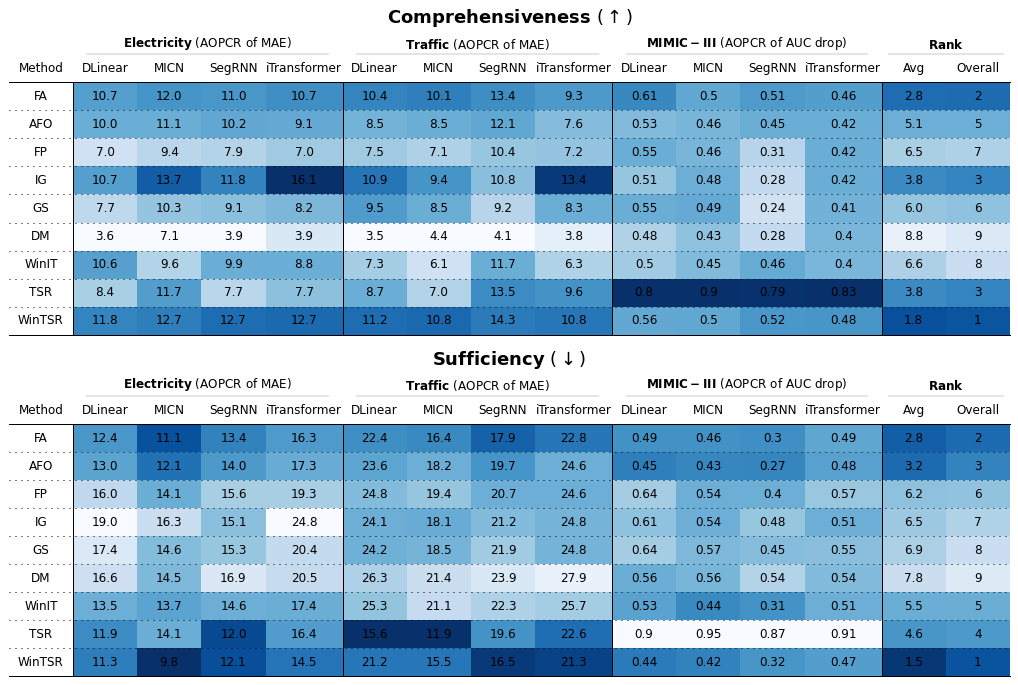

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
metrics_types = ['comp', 'suff']

for i in range(2):
    ax = axes[i]
    # dataset = datasets[i]
    
    merged = get_merged2(metrics_types[i])
    col_defs = get_definitions2(merged, metrics_types[i])

    table = Table(
        merged,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 12},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        # odd_row_color="#f0f0f0", even_row_color="#e0f6ff"
    )
    if metrics_types[i] == 'comp':
        ax.set_title(r'$\bf{Comprehensiveness}$ '+ r'($\uparrow$)', fontsize=18, y=.96)
    else:
        ax.set_title(r'$\bf{Sufficiency}$ ' + r'($\downarrow$)', fontsize=18, y=.96)
    # if dataset== 'mimic_iii':
    #     ax.set_title(f'{dataset_full_form[dataset]} (AOPC of AUC drop)', fontsize=16, y=.95)
    # else:
    #     ax.set_title(f'{dataset_full_form[dataset]} (AOPCR of Mean Absolute Error)', fontsize=16, y=.95)
    
plt.subplots_adjust(hspace=0.1)
# plt.savefig(f'results/table2.png', dpi=100, bbox_inches="tight")
plt.show()

# Time efficiency

In [26]:
time_efficiency = pd.read_csv('results/time_efficiency.csv')
time_efficiency = time_efficiency[time_efficiency['name'].isin(attr_methods)]
time_efficiency.head(3)

,dataset,model,iteration,name,timestamp,duration,settings
0,traffic,DLinear,1,feature_ablation,2024-07-26 00:28:04.747253,0:01:13.289547,NaN
1,electricity,DLinear,1,feature_ablation,2024-07-26 00:28:09.959615,0:01:49.416156,NaN
2,mimic_iii,DLinear,1,feature_ablation,2024-07-26 00:29:14.800882,0:01:51.229460,NaN


In [27]:
time_efficiency['minutes'] = pd.to_timedelta(time_efficiency['duration']).dt.seconds / 60
df = time_efficiency.groupby(['dataset', 'model', 'name'])['minutes'].mean().reset_index()
df

,dataset,model,name,minutes
0,electricity,DLinear,augmented_occlusion,1.972222
1,electricity,DLinear,dyna_mask,1.438889
2,electricity,DLinear,feature_ablation,1.827778
3,electricity,DLinear,feature_permutation,1.911111
4,electricity,DLinear,gradient_shap,1.483333
...,...,...,...,...
103,traffic,iTransformer,gradient_shap,2.522222
104,traffic,iTransformer,integrated_gradients,3.155556
105,traffic,iTransformer,tsr,404.204167
106,traffic,iTransformer,winIT,4.150000


In [29]:
df[df['name']=='tsr']['minutes'] / df[df['name']=='wtsr']['minutes'].values

6       93.601770
15     120.277179
24     284.464052
33     113.417180
42      40.206853
51      63.972388
60      62.908240
69      32.330548
78     154.066667
87     134.830680
96     367.777778
105     93.758698
Name: minutes, dtype: float64

## Write latex table

In [17]:
print("Dataset & Model & " + " & ".join([short_form[attr_method] for attr_method in attr_methods]) + " \\\\ \\hline")
for dataset in datasets:
    print("\multirow{4}{*}{" + f'{dataset_full_form[dataset]}' + "}", end='')
    for model in models:
        print(f' & {model}', end='')
        for attr_method in attr_methods:    
            value = df[(df['dataset']==dataset) & (df['model']==model) & (df['name']==attr_method)]['minutes'].values[0]
            print_row(value, decimals=1)
        print('\\\\ ')
    print('\\hline')

Dataset & Model & FA & AFO & FP & IG & GS & DM & WinIT & TSR & WinTSR \\ \hline
\multirow{4}{*}{Electricity} & DLinear& 1.8 & 2.0 & 1.9 & 2.3 & 1.5 & 1.4 & 2.8 & 176.3 & 1.9 \\ 
 & MICN& 6.4 & 6.6 & 6.5 & 7.1 & 4.6 & 4.5 & 7.4 & 682.2 & 5.7 \\ 
 & SegRNN& 2.6 & 2.8 & 2.7 & 2.8 & 2.0 & 2.0 & 3.6 & 725.4 & 2.6 \\ 
 & iTransformer& 5.2 & 5.4 & 5.3 & 4.6 & 3.7 & 3.6 & 6.2 & 716.4 & 6.3 \\ 
\hline
\multirow{4}{*}{Traffic} & DLinear& 1.2 & 1.3 & 1.3 & 1.6 & 1.0 & 0.9 & 1.8 & 192.6 & 1.2 \\ 
 & MICN& 4.4 & 4.5 & 4.4 & 4.6 & 3.1 & 3.0 & 5.0 & 517.6 & 3.8 \\ 
 & SegRNN& 1.8 & 1.8 & 1.8 & 1.9 & 1.3 & 1.3 & 2.3 & 625.2 & 1.7 \\ 
 & iTransformer& 3.5 & 3.6 & 3.6 & 3.2 & 2.5 & 2.5 & 4.2 & 404.2 & 4.3 \\ 
\hline
\multirow{4}{*}{MIMIC-III} & DLinear& 1.9 & 2.2 & 2.1 & 0.4 & 0.3 & 0.5 & 6.8 & 176.0 & 4.4 \\ 
 & MICN& 6.9 & 7.3 & 7.1 & 0.8 & 0.6 & 0.8 & 12.0 & 476.2 & 7.4 \\ 
 & SegRNN& 3.8 & 4.7 & 4.7 & 0.8 & 0.5 & 0.6 & 7.9 & 373.3 & 5.9 \\ 
 & iTransformer& 5.2 & 5.6 & 5.4 & 0.6 & 0.5 & 0.7 & 10.2 &

## Overall rank

In [18]:
df.loc[:, 'rank'] = df.groupby(['dataset', 'model'])['minutes'].rank()
time_ranks = df.groupby('name')['rank'].mean().reset_index()
time_ranks['Overall'] = time_ranks['rank'].rank()
time_ranks

,name,rank,Overall
0,augmented_occlusion,6.000000,7.0
1,dyna_mask,1.500000,1.0
2,feature_ablation,3.833333,3.0
3,feature_permutation,5.000000,5.0
4,gradient_shap,1.666667,2.0
5,integrated_gradients,4.833333,4.0
6,tsr2,9.000000,9.0
7,winIT,7.833333,8.0
8,wtsr,5.333333,6.0


## Boxplot

In [65]:
# from utils.plot_config import *

# rows, columns = 3, 4
# fig, axes = plt.subplots(rows, columns, figsize=(32, 10), sharex=True, sharey=True)

# for row in range(rows):
#     for col in range(columns):
#         ax = axes[row][col]
#         dataset = datasets[row]
#         model = models[col]
#         df = time_efficiency[(time_efficiency['dataset']==dataset) & (time_efficiency['model']==model)]
#         # df['name'] = df['name'].apply(lambda x: short_form[x])
        
#         df = df.groupby('name')['minutes'].mean().reset_index()
#         df['minutes']  = df['minutes'].apply(np.log10)
#         df.plot(x='name', y='minutes', ax=ax, kind='bar', legend=False, rot=90)
#         ax.set_xlabel('')
#         if row == 0:
#             ax.set_title(model)
#         if col == 0:
#             ax.set_ylabel(dataset_full_form[dataset])
            
# fig.supylabel('Log Time (minute)', fontsize=36, x=0.073, y=0.5)
# plt.show()

In [135]:
df = time_efficiency.groupby(['dataset', 'model', 'name'])['minutes'].mean().reset_index()

(0.0, 4.870654764399365)
(0.0, 4.802894938903227)
(0.0, 4.678774912011633)


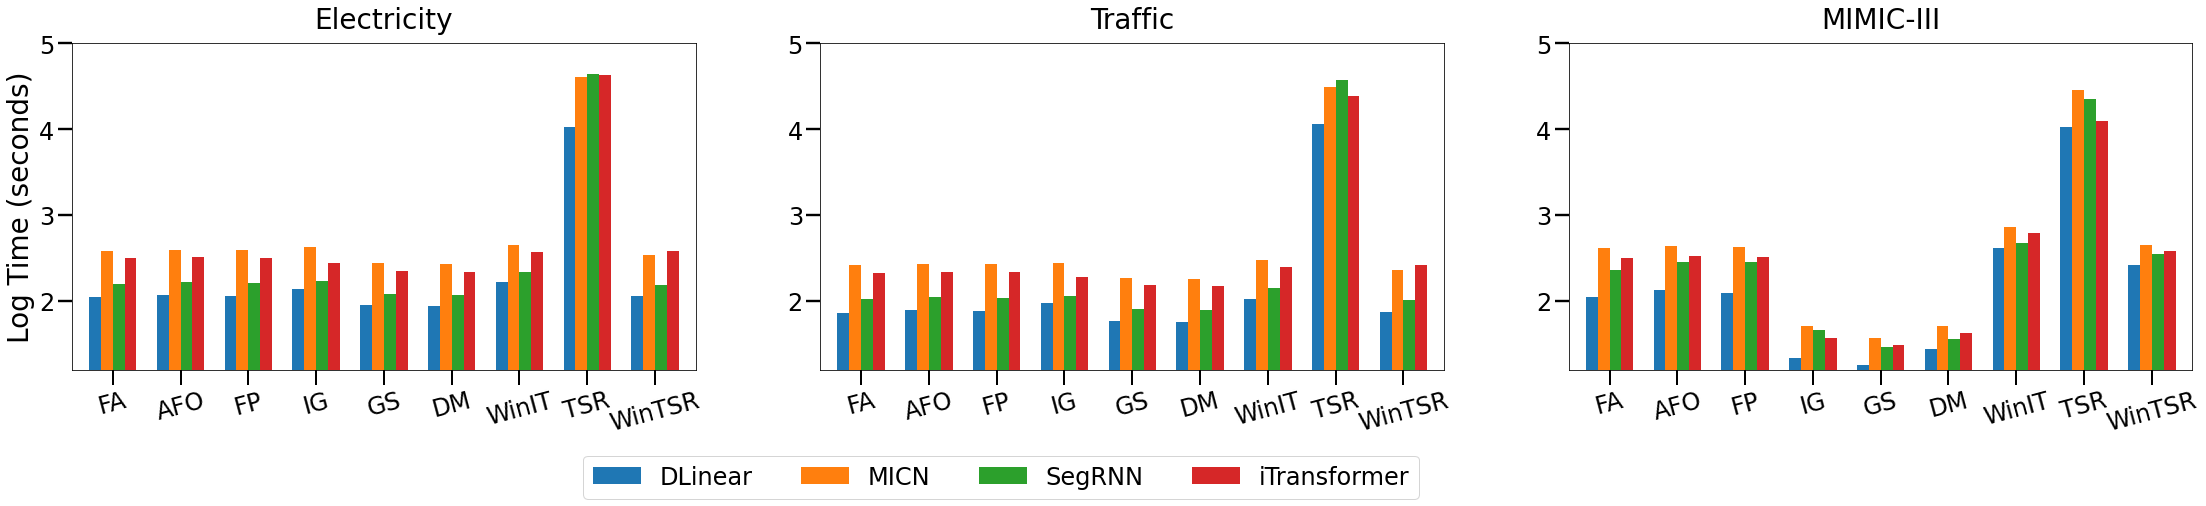

In [19]:
fig, axes = plt.subplots(1, len(datasets), figsize=(38, 6),)
for i, dataset in enumerate(datasets):
    temp = df[df['dataset']==dataset].copy()
    temp['name'] = temp['name'].apply(lambda x: short_form[x])
    temp['minutes'] *= 60
    temp['minutes'] = temp['minutes'].apply(np.log10)
    temp = temp.pivot(index='name', columns='model', values='minutes')
    
    # order the names
    temp = temp.loc[[short_form[name] for name in attr_methods]]
    
    if i == 0:
        temp.plot.bar(rot=15, legend=False, ylabel='Log Time (seconds)', xlabel='', ax=axes[i], width=0.7)
    else: 
        temp.plot.bar(rot=15, legend=False, ylabel='', xlabel='', ax=axes[i], width=0.7)
    axes[i].set_title(dataset_full_form[dataset])
    
    print(axes[i].get_ylim())
    
    axes[i].set_ylim(1.2, 5)
    ax.xaxis.set_major_locator(MultipleLocator(base=1))
    
    # axes[i].grid()
    if i == len(axes) // 2:
        axes[i].legend(loc='center left', bbox_to_anchor=(-.4, -0.33), ncol=4)

plt.savefig(f'results/time efficiency.jpg', dpi=100, bbox_inches="tight")

# Variable Lookback

In [20]:
lookbacks = {
    'electricity':[24, 48], 
    'traffic': [24, 48], 
    'mimic_iii': [24, 36]
}
model = 'iTransformer'
results = []
for dataset in datasets:
    for attr_method in attr_methods[-3:]:
        for metric in int_metric_map[dataset]:
            for lookback in lookbacks[dataset]:
                for itr_no in range(1, NUM_ITERATIONS+1):
                    filepath = f'results/{dataset}_{model}_sl_{lookback}/{itr_no}/{attr_method}.csv'
                    if not os.path.exists(filepath): continue
                    
                    df = pd.read_csv(filepath)
                    df = reduce_df(df)
                    comp, suff= df[df['metric']==metric][['comp', 'suff']].values[0]
                    
                    results.append([
                        dataset, attr_method, metric, lookback, itr_no, comp, suff
                    ])
                    

result_df = pd.DataFrame(results, columns=['dataset', 'attr_method', 'metric', 'lookback', 'itr_no', 'comp', 'suff'])
result_df = result_df.groupby(['dataset', 'attr_method', 'metric', 'lookback'])[['comp', 'suff']].mean().reset_index()

In [26]:
for dataset in datasets:
    print("\multirow{3}{*}{" + f' {dataset}' + "}", end='')
    for attr_method in attr_methods[-3:]:
        print(f' & {short_form[attr_method]}', end='')
        for metric in int_metric_map[dataset]:
            for lookback in lookbacks[dataset]:
                values = result_df[
                    (result_df['dataset']==dataset) & (result_df['attr_method']==attr_method) & (result_df['metric']==metric) & (result_df['lookback']==lookback)
                ][['comp', 'suff']].values[0]
                
                if metric in ['auc', 'accuracy']:
                    values = 1 - values
                    
                print(f' & {values[0]:.2f} & {values[1]:.2f}', end='')
        print('\\\\')
    print('\\hline')

\multirow{3}{*}{ electricity} & WinIT & 14.38 & 22.973 & 11.47 & 17.860\\
 & TSR & 7.81 & 21.524 & 8.15 & 16.019\\
 & WinTSR & 17.88 & 20.678 & 14.85 & 15.264\\
\hline
\multirow{3}{*}{ traffic} & WinIT & 9.10 & 25.464 & 7.50 & 26.119\\
 & TSR & 6.10 & 25.875 & 7.49 & 23.164\\
 & WinTSR & 11.39 & 23.275 & 11.32 & 22.714\\
\hline
\multirow{3}{*}{ mimic_iii} & WinIT & 0.55 & 0.629 & 0.45 & 0.553\\
 & TSR & 0.87 & 0.929 & 0.83 & 0.910\\
 & WinTSR & 0.59 & 0.634 & 0.49 & 0.487\\
\hline


In [23]:
result_df.round(2).to_csv('results/var_seq_length.csv', index=False)